In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
import os

# make a color map dictionary for datasets
datasets = ['jones', 'stiffler', 'haddox', 'doud', 'lee', 'kelsic', 'brenan', 'giacomelli', 'markin']
color_map = {dataset: plt.cm.tab20(i) for i, dataset in enumerate(datasets)}

# show the colors of the color map
for dataset in datasets:
    print(dataset, color_map[dataset])

jones (0.12156862745098039, 0.4666666666666667, 0.7058823529411765, 1.0)
stiffler (0.6823529411764706, 0.7803921568627451, 0.9098039215686274, 1.0)
haddox (1.0, 0.4980392156862745, 0.054901960784313725, 1.0)
doud (1.0, 0.7333333333333333, 0.47058823529411764, 1.0)
lee (0.17254901960784313, 0.6274509803921569, 0.17254901960784313, 1.0)
kelsic (0.596078431372549, 0.8745098039215686, 0.5411764705882353, 1.0)
brenan (0.8392156862745098, 0.15294117647058825, 0.1568627450980392, 1.0)
giacomelli (1.0, 0.596078431372549, 0.5882352941176471, 1.0)
markin (0.5803921568627451, 0.403921568627451, 0.7411764705882353, 1.0)


In [8]:
def name_dataset(df, name, embedding_type = None, esm_type = None):
    df['dataset'] = name
    if embedding_type is not None:
        df['embedding_type'] = embedding_type
    if esm_type is not None:
        df['esm_type'] = esm_type
    return df

def left_join_hie(df):
    # Read the file
    comparison = {'dataset': ['jones', 'stiffler', 'haddox', 'doud', 'lee', 'kelsic', 'brenan', 'giacomelli', 'markin'],
                  'comparison': [0.22, 0.40, 0.23, 0.16, 0.31, 0.50, 0.077, 0.12, 0.20]}
    comparison = pd.DataFrame(comparison)

    # Merge the two dataframes
    df = pd.merge(df, comparison, on='dataset', how='left')

    return df

def plot_num_iterations_vs_output(df, output_var, num_mutants_per_round, ax=None, comparison=False):
    if ax is None:
        plt.figure(figsize=(10, 6))
        ax = plt.gca()

    # Filter the DataFrame based on num_mutants_per_round
    filtered_df = df[df['num_mutants_per_round'] == num_mutants_per_round]

    # Left join the comparison values
    filtered_df = left_join_hie(filtered_df)

    # Create a color map for datasets
    # color_map = {dataset: plt.cm.tab20(i) for i, dataset in enumerate(datasets)}

    # Get unique datasets from the DataFrame
    datasets = filtered_df['dataset'].unique()

    # Plot each dataset as a separate line
    for i, dataset in enumerate(datasets):
        dataset_df = filtered_df[filtered_df['dataset'] == dataset]
        x_values = dataset_df['num_iterations']
        y_values = dataset_df[output_var]
        color = color_map[dataset]
        label = f'{dataset}'
        ax.plot(x_values, y_values, color=color, marker='o', label=label)

        if comparison:
            comparisons = dataset_df['comparison']
            for j, comparison_value in enumerate(comparisons):
                if not np.isnan(comparison_value):
                    # Create an interpolation function for the line
                    line_interp = interp1d(x_values, y_values, kind='linear', fill_value='extrapolate')

                    # Find the intersection point with the comparison value
                    intersection_x = np.interp(comparison_value, y_values, x_values)
                    intersection_y = line_interp(intersection_x)

                    # Plot the dash marker at the intersection point

                    ax.scatter(intersection_x, intersection_y, color='black', s=200, marker='_', zorder=5, label='_nolegend_')


    # Set plot labels and title
    ax.set_xlabel('Number of Iterations')
    ax.set_ylabel(output_var)
    ax.set_title(f'{output_var} vs. Number of Iterations (num_mutants_per_round={num_mutants_per_round}), esm2')

    # Add legend to the right side of the plot
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

    # Show the plot if it was newly created
    if ax is None:
        plt.show()

def generate_plots(esm="esm1b"):
    file_names_list = ["kelsic", "brenan", "stiffler", "markin", "giacomelli", "jones", "haddox", "doud", "lee"]
    individual_dfs = []

    for file_name in file_names_list:
        # Read the file
        if esm == "esm1b":
            file_path = f"{file_name}_{esm}_t33_650M_UR50S_results.csv"
        else:
            file_path = f"{file_name}_{esm}_t33_650M_UR50D_results.csv"
        individual_df = pd.read_csv(file_path)

        # Rename the columns
        individual_df = name_dataset(individual_df, file_name)

        # Save the scaled dataframe in the list
        individual_dfs.append(individual_df)

    # Concatenate all the scaled dataframes
    df = pd.concat(individual_dfs)

    fig, axes = plt.subplots(3, 1, figsize=(10, 18))

    # Plot 1
    plot_num_iterations_vs_output(df, 'last_median_fitness_scaled', num_mutants_per_round=16, ax=axes[0], comparison=False)
    axes[0].set_title('Median scaled last round fitness (0-1)')

    # Plot 2
    plot_num_iterations_vs_output(df, 'last_top_fitness_scaled', num_mutants_per_round=16, ax=axes[1], comparison=False)
    axes[1].set_title('Top scaled last round fitness (0-1)')

    # Plot 3
    plot_num_iterations_vs_output(df, 'last_fitness_binary_percentage', num_mutants_per_round=16, ax=axes[2], comparison=True)
    axes[2].set_title('Last round percent high fitness (0-100%)')

    plt.tight_layout(rect=[0, 0.03, 1, 0.97])  # Adjust the top margin to make room for the overarching title
    fig.suptitle(f"Metrics across rounds of simulated directed evolution ({esm})", fontsize=16, y=0.98)  # Set y to control the vertical position
    plt.show()

    return df

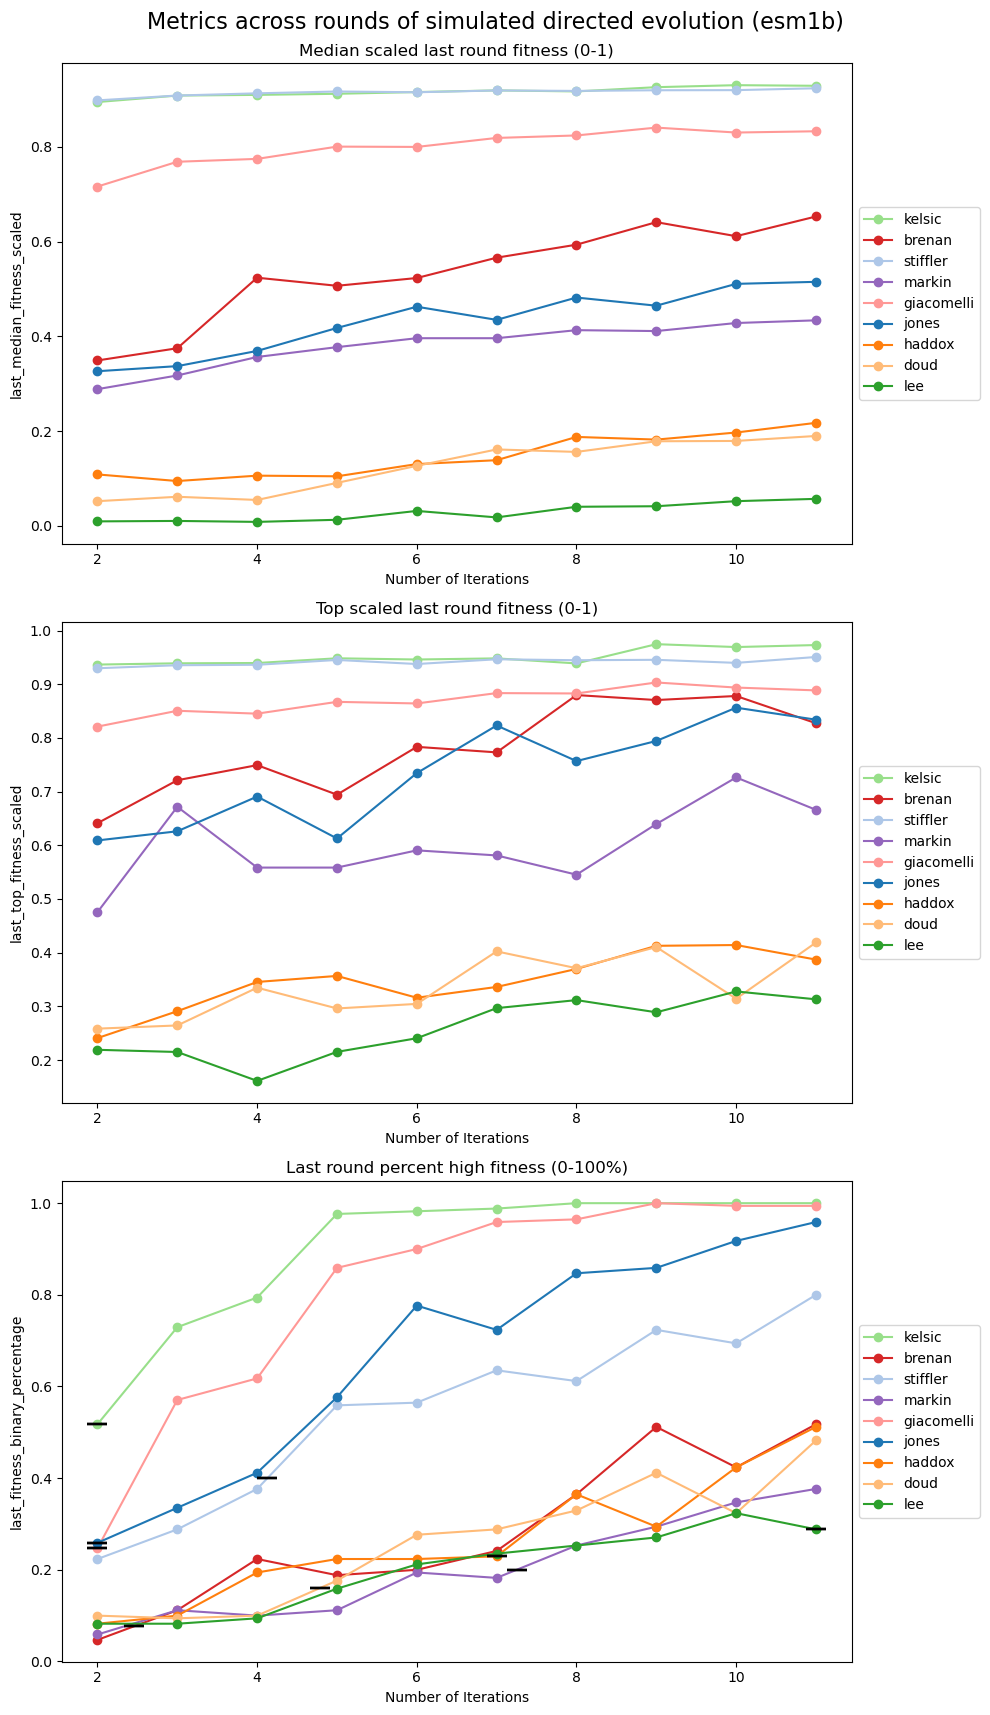

In [3]:
generate_plots(esm="esm1b")

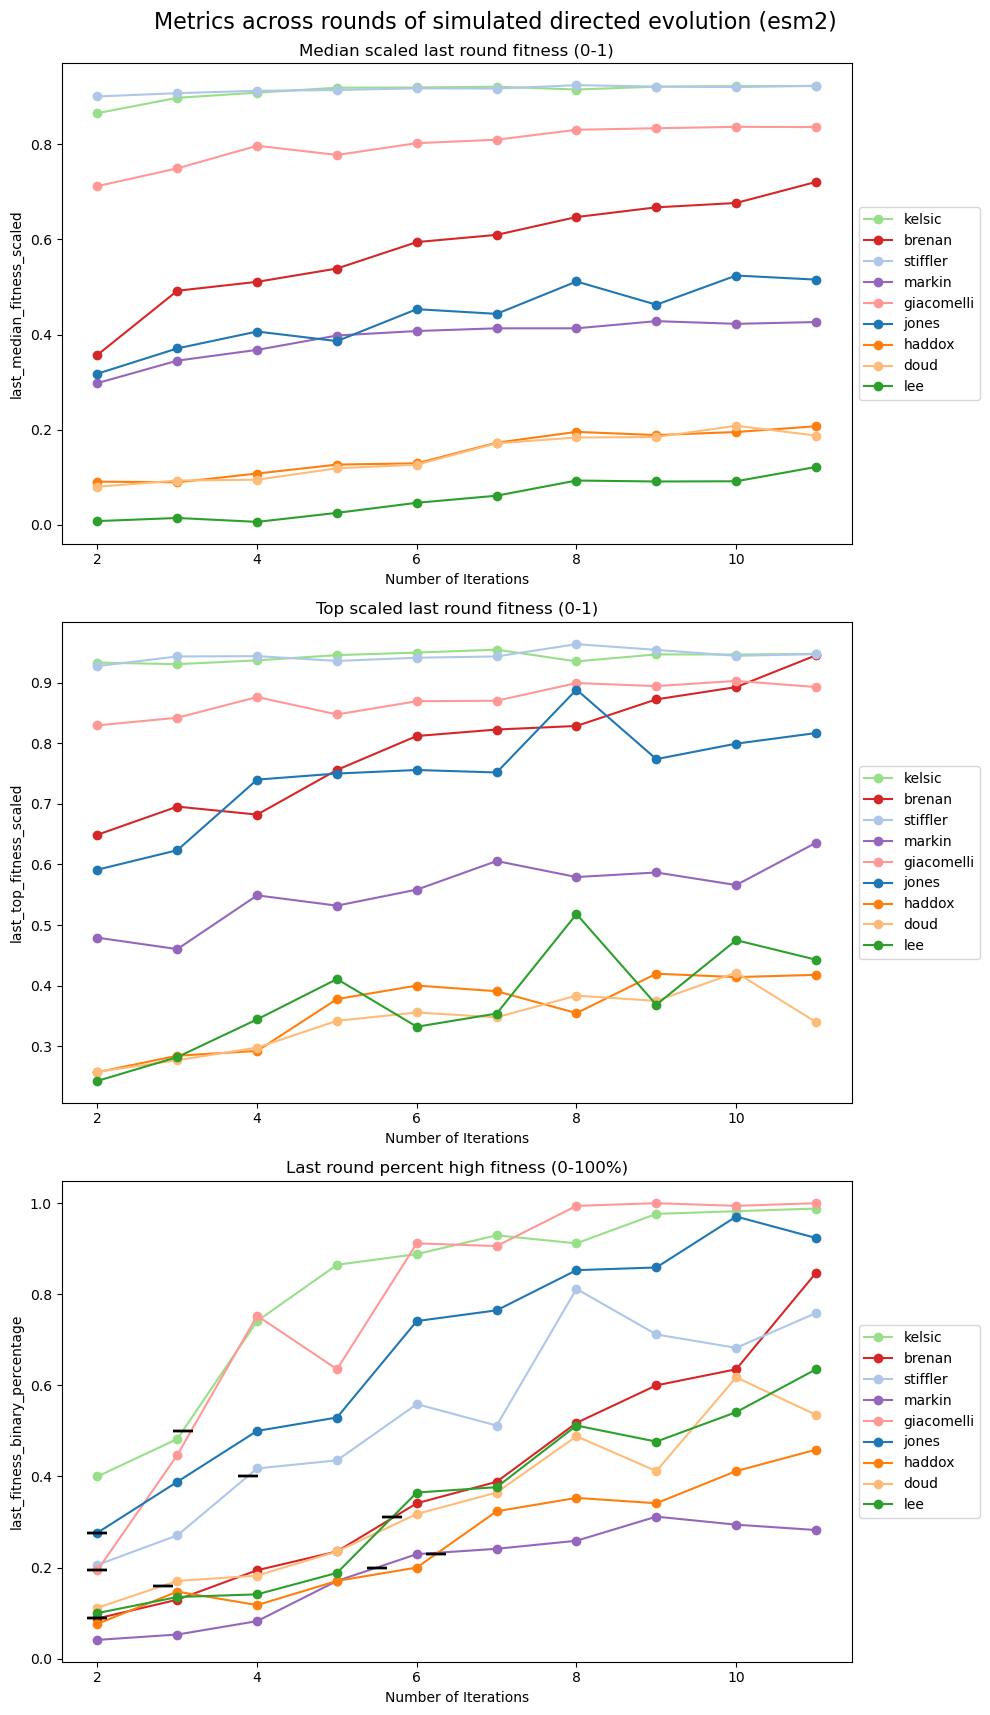

In [4]:
generate_plots(esm="esm2")

In [5]:
def plot_num_iterations_vs_output_new(df, output_var, num_mutants_per_round, ax=None, comparison=False):
    if ax is None:
        plt.figure(figsize=(10, 6))
        ax = plt.gca()

    # Filter the DataFrame based on num_mutants_per_round
    filtered_df = df[df['num_mutants_per_round'] == num_mutants_per_round]

    # Left join the comparison values
    filtered_df = left_join_hie(filtered_df)

    # Create a color map for datasets
    datasets = filtered_df['dataset'].unique()
    # color_map = {dataset: plt.cm.tab20(i) for i, dataset in enumerate(datasets)}

    # Create a line map based on embedding type
    embedding_types = filtered_df['embedding_type'].unique()
    line_map = {embedding_type: linestyle for embedding_type, linestyle in zip(embedding_types, ['-', '--', ':'])}

    # Plot each dataset and embedding type as a separate line
    for i, dataset in enumerate(datasets):
        for j, embedding_type in enumerate(embedding_types):
            dataset_df = filtered_df[(filtered_df['dataset'] == dataset) & (filtered_df['embedding_type'] == embedding_type)]
            x_values = dataset_df['num_iterations']
            y_values = dataset_df[output_var]
            color = color_map[dataset]  # Corrected line
            linestyle = line_map[embedding_type]

            ax.plot(x_values, y_values, color=color, linestyle=linestyle, marker='o', label=f'{dataset} ({embedding_type})')


            if comparison:
                comparisons = dataset_df['comparison']
                for k, comparison_value in enumerate(comparisons):
                    if not np.isnan(comparison_value):
                        # Create an interpolation function for the line
                        line_interp = interp1d(x_values, y_values, kind='linear', fill_value='extrapolate')

                        # Find the intersection point with the comparison value
                        intersection_x = np.interp(comparison_value, y_values, x_values)
                        intersection_y = line_interp(intersection_x)

                        # Plot the dash marker at the intersection point
                        ax.scatter(intersection_x, intersection_y, color='black', s=200, marker='_', zorder=5, label='_nolegend_')

    # Manually create a legend for dataset/color
    dataset_legend_handles = []
    for dataset in datasets:
        color = color_map[dataset]
        label = f'{dataset}'
        dataset_legend_handles.append(ax.plot([], [], color=color, label=label)[0])

    dataset_legend = ax.legend(handles=dataset_legend_handles, loc='upper left', bbox_to_anchor=(1.05, 1), title='Dataset', frameon=False)

    # Manually create a legend for embedding type/linestyle
    embedding_legend_handles = []
    for embedding_type in embedding_types:
        linestyle = line_map[embedding_type]
        label = f'{embedding_type}'
        embedding_legend_handles.append(ax.plot([], [], color = 'black', linestyle=linestyle, label=label)[0])

    embedding_legend = ax.legend(handles=embedding_legend_handles, loc='upper left', bbox_to_anchor=(1.05, 0.5), title='Embedding Type', frameon=False)

    # Add the legends back to the plot
    ax.add_artist(dataset_legend)
    ax.add_artist(embedding_legend)


    # Set plot labels and title
    ax.set_xlabel('Number of Iterations')
    ax.set_ylabel(output_var)
    ax.set_title(f'{output_var} vs. Number of Iterations (num_mutants_per_round={num_mutants_per_round}), esm2')

    # Show the plot if it was newly created
    if ax is None:
        plt.show()


def generate_plots_new(esm="esm2"):
    file_suffixes = ["average", "both", "mutated"]
    file_names_list = ["brenan", "doud", "giacomelli", "haddox", "jones", "kelsic", "lee", "markin", "stiffler"]
    individual_dfs = []

    for file_name in file_names_list:
        for suffix in file_suffixes:
            file_path = f"results/{esm}_{file_name}_{suffix}_results.csv"
            # Read the file
            individual_df = pd.read_csv(file_path)

            # Rename the columns
            individual_df = name_dataset(individual_df, file_name, embedding_type=suffix)

            # Save the scaled dataframe in the list
            individual_dfs.append(individual_df)

    # Concatenate all the scaled dataframes
    df = pd.concat(individual_dfs)

    # Plot the results
    fig, axes = plt.subplots(3, 1, figsize=(10, 18))

    # Plot 1
    plot_num_iterations_vs_output_new(df, 'last_median_fitness_scaled', num_mutants_per_round=16, ax=axes[0], comparison=False)
    axes[0].set_title('Median scaled last round fitness (0-1)')

    # Plot 2
    plot_num_iterations_vs_output_new(df, 'last_top_fitness_scaled', num_mutants_per_round=16, ax=axes[1], comparison=False)
    axes[1].set_title('Top scaled last round fitness (0-1)')

    # Plot 3
    plot_num_iterations_vs_output_new(df, 'last_fitness_binary_percentage', num_mutants_per_round=16, ax=axes[2], comparison=True)
    axes[2].set_title('Last round percent high fitness (0-100%)')

    plt.tight_layout(rect=[0, 0.03, 1, 0.97])  # Adjust the top margin to make room for the overarching title
    fig.suptitle(f"Metrics across rounds of simulated directed evolution ({esm})", fontsize=16, y=0.98)  # Set y to control the vertical position
    plt.show() 


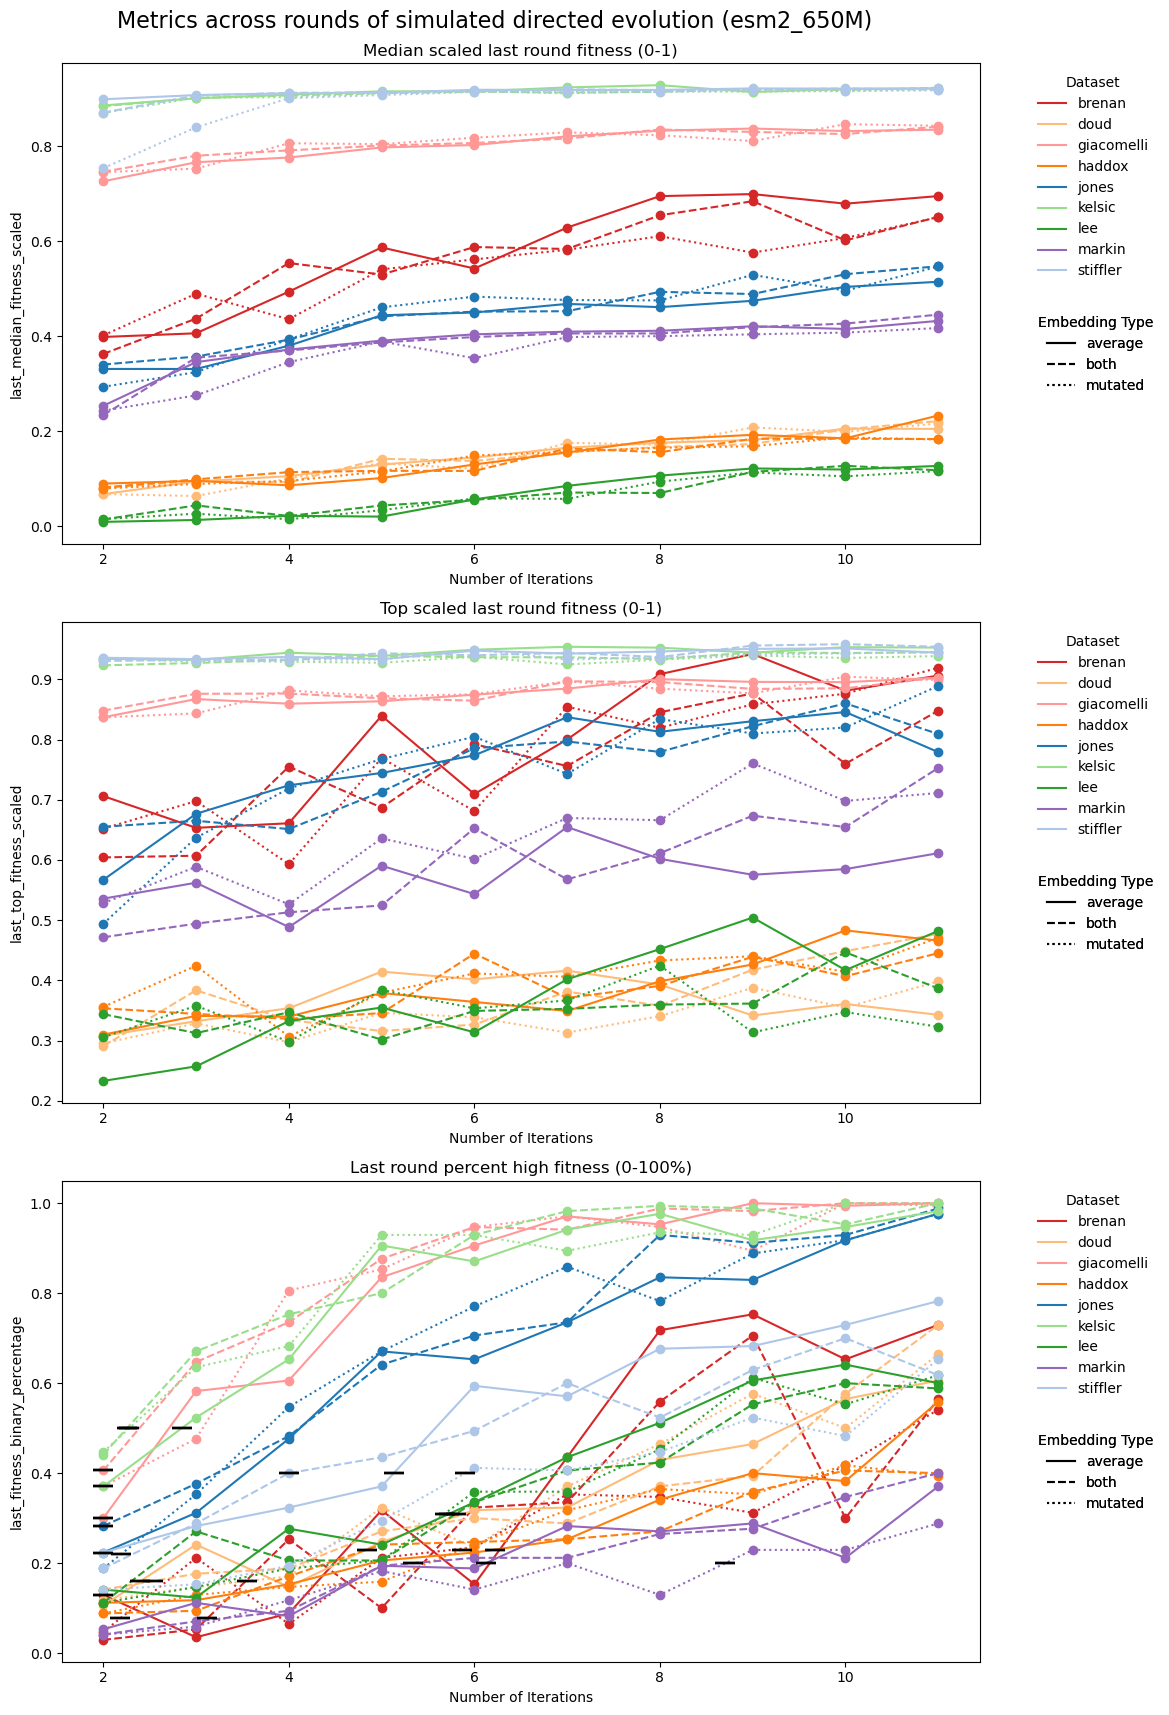

In [6]:
generate_plots_new('esm2_650M')

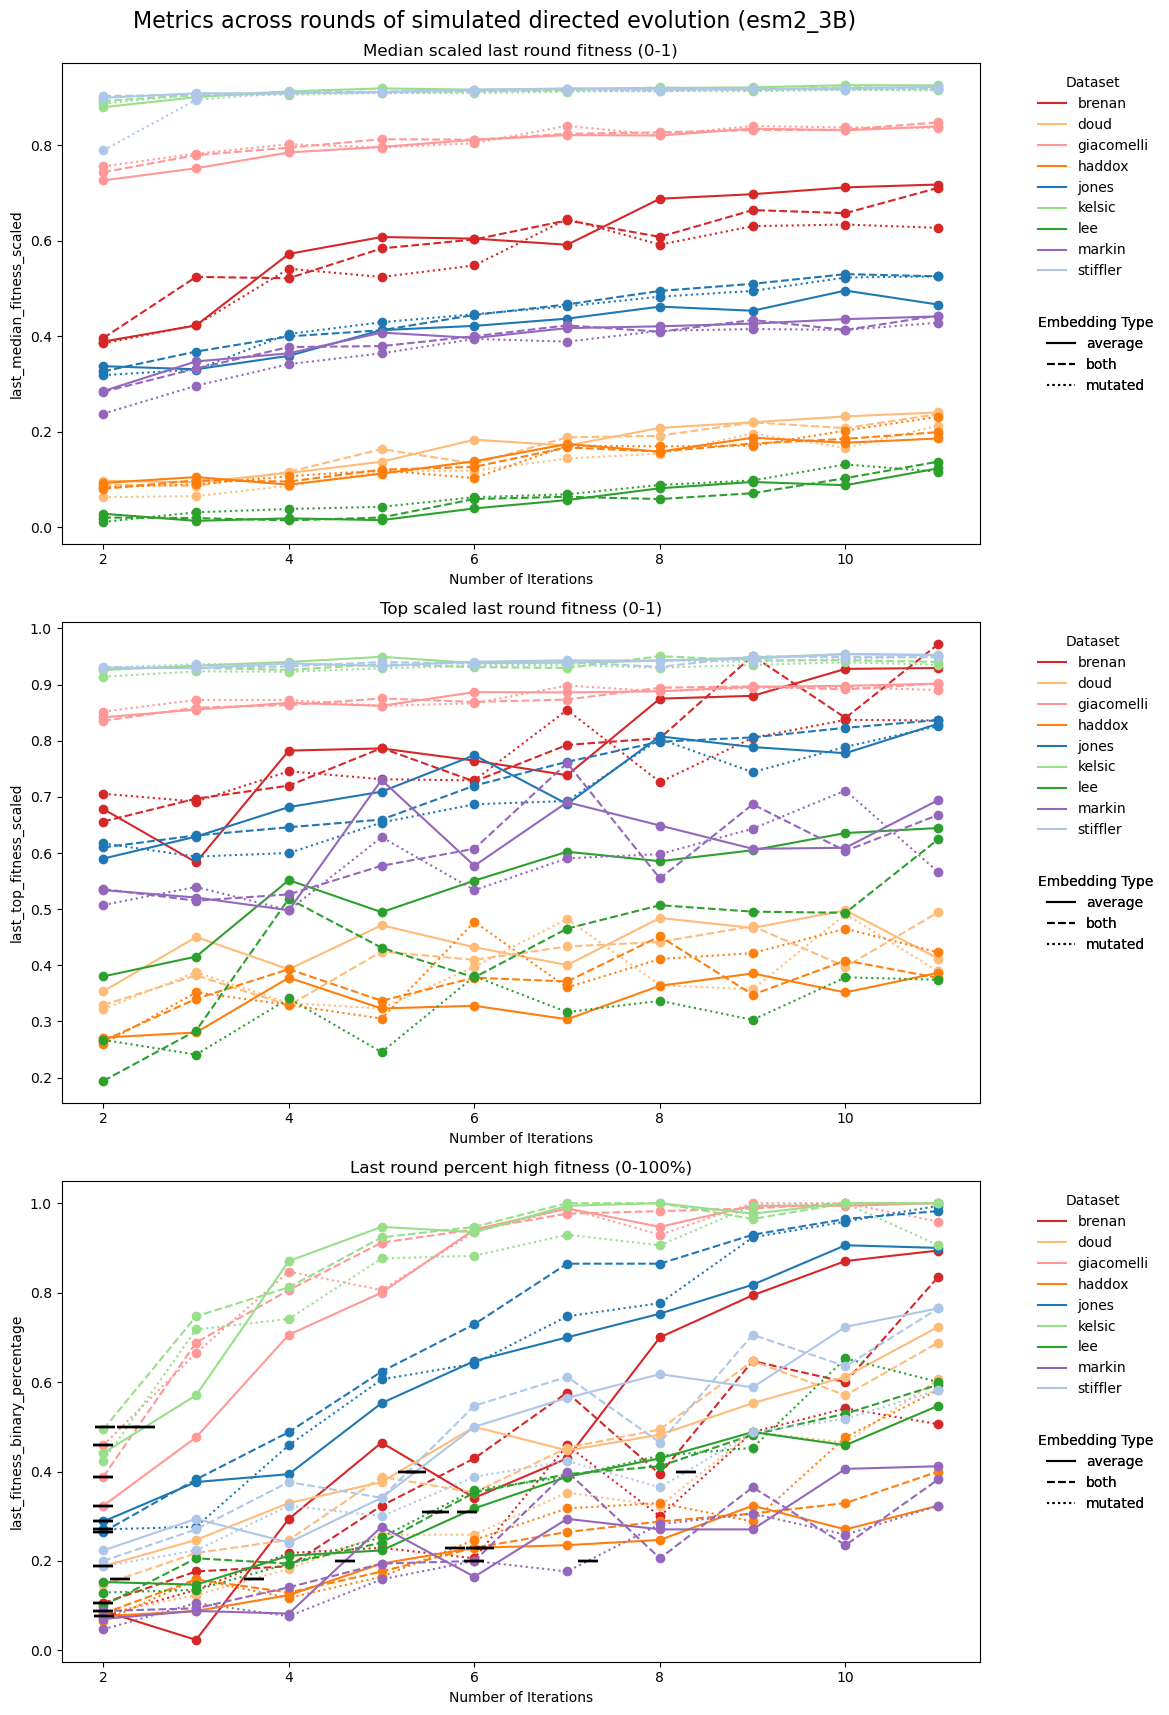

In [7]:
generate_plots_new('esm2_3B')

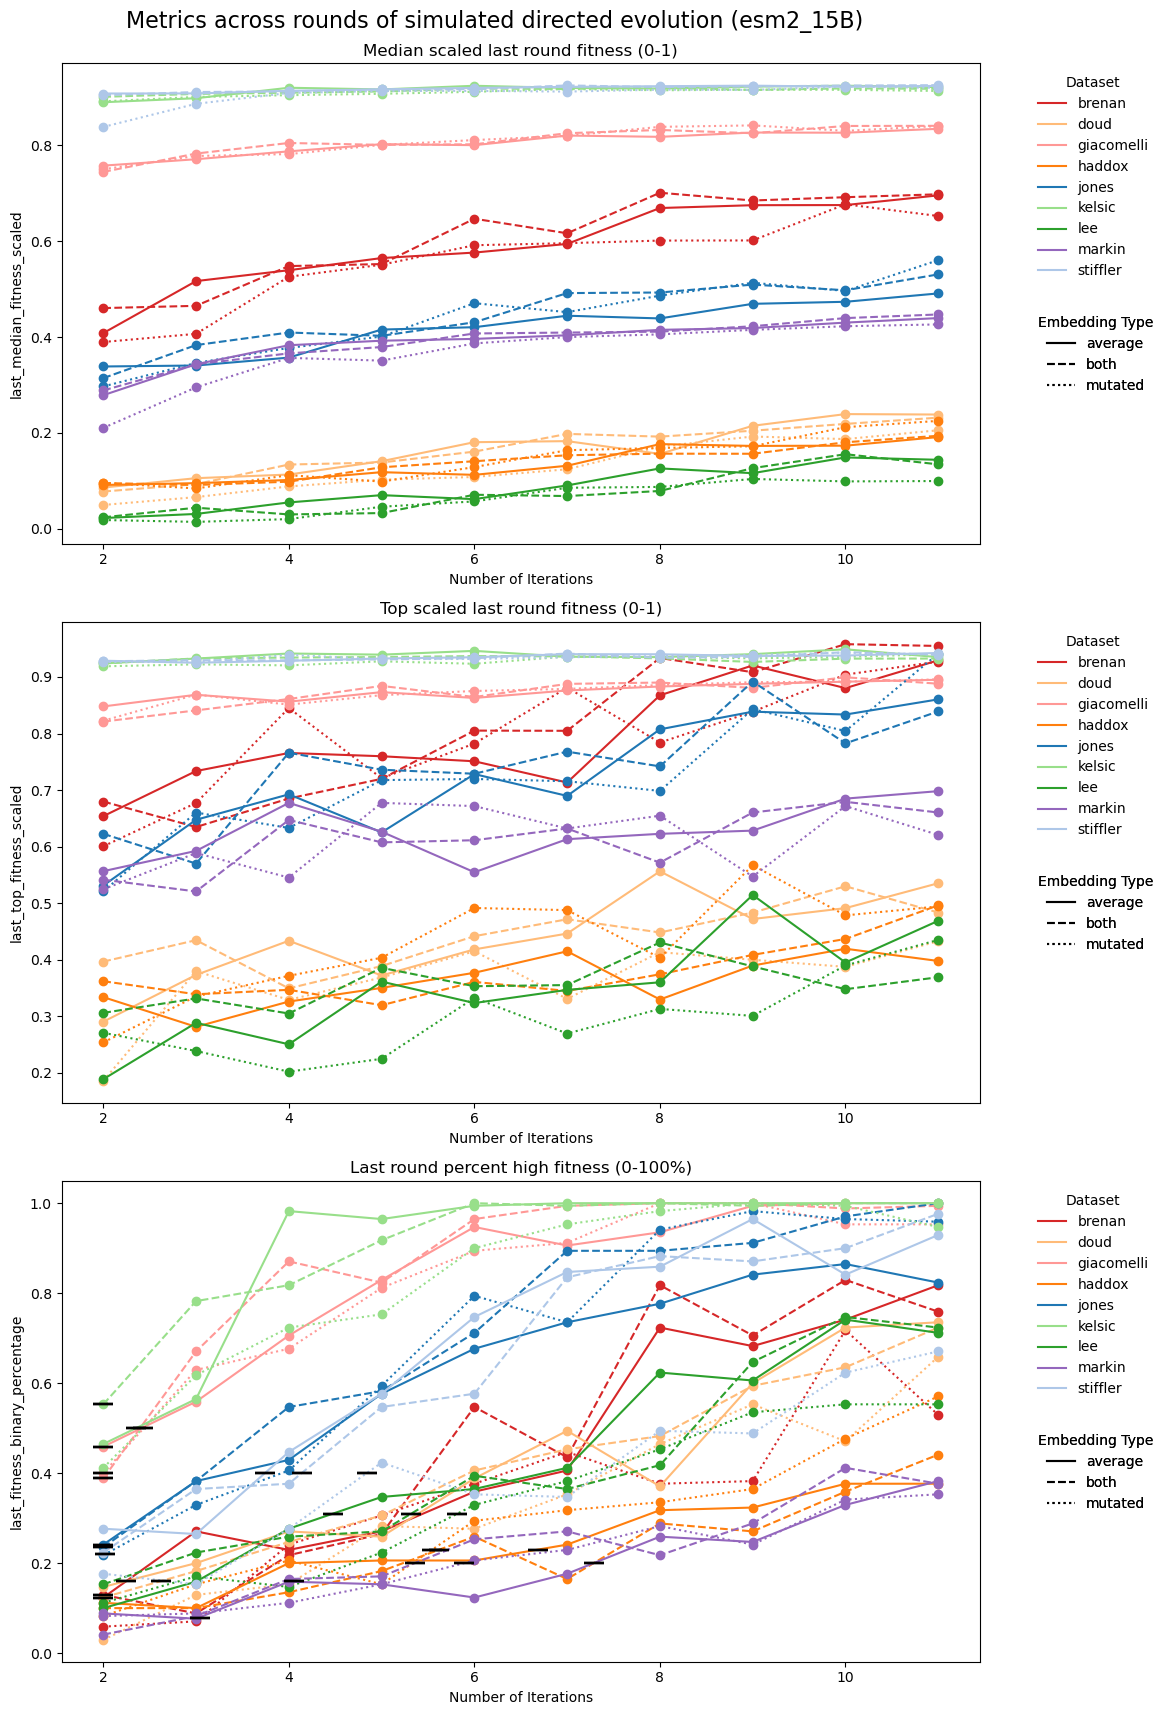

In [ ]:
generate_plots_new('esm2_15B')

In [9]:
import os
import pandas as pd

file_suffixes = ["average", "both", "mutated"]
file_names_list = ["brenan", "doud", "giacomelli", "haddox", "jones", "kelsic", "lee", "markin", "stiffler"]
esm_values = ["esm2_650M", "esm2_3B", "esm2_15B"]

all_dataframes = []

for esm in esm_values:
    for file_name in file_names_list:
        for suffix in file_suffixes:
            file_path = os.path.join("results", f"{esm}_{file_name}_{suffix}_results.csv")
            if os.path.exists(file_path):  # Check if the file exists before trying to read it
                # Read the file
                individual_df = pd.read_csv(file_path)

                # Rename the columns
                individual_df = name_dataset(individual_df, file_name, embedding_type=suffix, esm_type=esm)

                # Save the scaled dataframe in the list
                all_dataframes.append(individual_df)

df = pd.concat(all_dataframes)

In [14]:
df = df[df['num_iterations'] == 5]
df = df[df['embedding_type'] == 'average']
df = df[df['esm_type'] == 'esm2_15B']
# only subset to the last_median_fitness_scaled and dataset
df = df[['dataset', 'last_median_fitness_scaled']]
df

,dataset,last_median_fitness_scaled
3,brenan,0.564789
3,doud,0.141166
3,giacomelli,0.802262
3,haddox,0.118263
3,jones,0.415663
3,kelsic,0.916422
3,lee,0.070349
3,markin,0.392429
3,stiffler,0.916564


      dataset embedding_type   esm_type  last_fitness_binary_percentage
3      brenan        average    esm2_3B                        0.464706
3        doud           both    esm2_3B                        0.388235
3  giacomelli           both    esm2_3B                        0.911765
3      haddox           both  esm2_650M                        0.241176
3       jones        average  esm2_650M                        0.670588
3       jones        mutated  esm2_650M                        0.670588
3      kelsic        average   esm2_15B                        0.964706
3         lee        average   esm2_15B                        0.347059
3      markin        average    esm2_3B                        0.276471
3    stiffler        average   esm2_15B                        0.576471


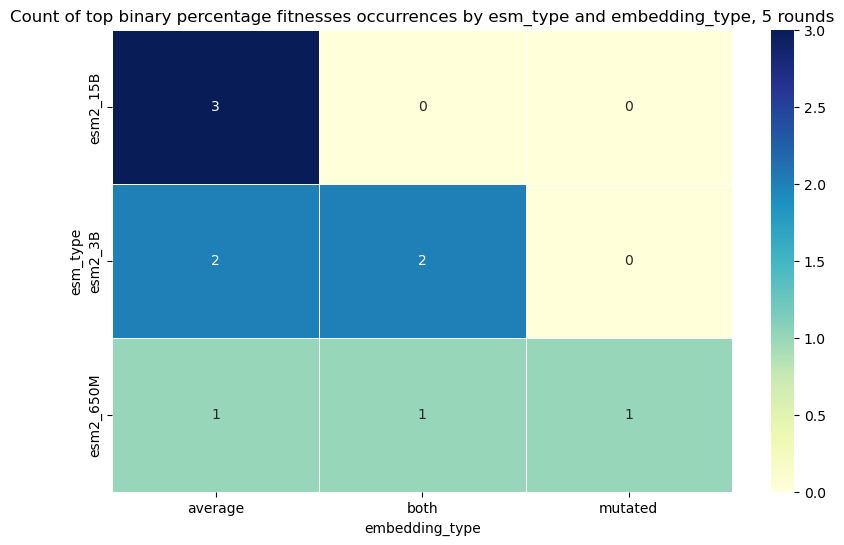

In [ ]:
# Subset df to num_iterations = 11
df_5 = df[df['num_iterations'] == 5]

# Find the row with the highest last_fitness_binary_percentage for each dataset
idx = df_5.groupby('dataset')['last_fitness_binary_percentage'].transform(max) == df_5['last_fitness_binary_percentage']
result = df_5.loc[idx]

# Sort by dataset
result = result.sort_values(by=['dataset'])

# Subset to only dataset, last_fitness_binary_percentage, embedding_type, esm_type
result = result[['dataset', 'embedding_type', 'esm_type', 'last_fitness_binary_percentage']]

print(result)

# Create a pivot table with count of occurrences
pivot_table = result.pivot_table(index='esm_type', columns='embedding_type', values='dataset', aggfunc='count', fill_value=0)

# Create a heatmap using seaborn
plt.figure(figsize=(10, 6))
sns.heatmap(pivot_table, annot=True, cmap='YlGnBu', fmt='d', linewidths=0.5)
plt.title('Count of top binary percentage fitnesses occurrences by esm_type and embedding_type, 5 rounds')
plt.show()

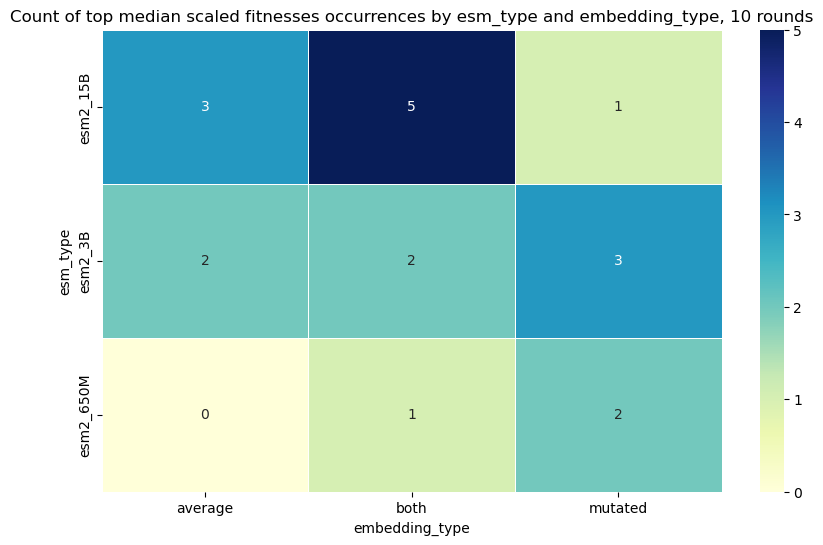

In [150]:
# Subset df to num_iterations = 11
df_10 = df[df['num_iterations'] == 10]

# Find the row with the highest last_fitness_binary_percentage for each dataset
idx = df_10.groupby('dataset')['last_fitness_binary_percentage'].transform(max) == df_10['last_fitness_binary_percentage']
result = df_10.loc[idx]

# Sort by dataset
result = result.sort_values(by=['dataset'])

# Subset to only dataset, last_fitness_binary_percentage, embedding_type, esm_type
result = result[['dataset', 'embedding_type', 'esm_type', 'last_fitness_binary_percentage']]

# Create a pivot table with count of occurrences
pivot_table = result.pivot_table(index='esm_type', columns='embedding_type', values='dataset', aggfunc='count', fill_value=0)

# Create a heatmap using seaborn
plt.figure(figsize=(10, 6))
sns.heatmap(pivot_table, annot=True, cmap='YlGnBu', fmt='d', linewidths=0.5)
plt.title('Count of top median scaled fitnesses occurrences by esm_type and embedding_type, 10 rounds')
plt.show()

In [ ]:
def plot_num_iterations_vs_output_first_round(df, output_var, num_mutants_per_round, ax=None, comparison=False):
    if ax is None:
        plt.figure(figsize=(10, 6))
        ax = plt.gca()

    # Filter the DataFrame based on num_mutants_per_round
    filtered_df = df[df['num_mutants_per_round'] == num_mutants_per_round]

    # Left join the comparison values
    filtered_df = left_join_hie(filtered_df)

    # Create a color map for datasets
    datasets = filtered_df['dataset'].unique()
    # color_map = {dataset: plt.cm.tab20(i) for i, dataset in enumerate(datasets)}

    # Create a line map based on first round strategy
    first_round_strategies = filtered_df['first_round_strategy'].unique()
    line_map = {strategy: linestyle for strategy, linestyle in zip(first_round_strategies, ['-', '--', ':'])}

    # Plot each dataset and first round strategy as a separate line
    for i, dataset in enumerate(datasets):
        for j, strategy in enumerate(first_round_strategies):
            dataset_df = filtered_df[(filtered_df['dataset'] == dataset) & (filtered_df['first_round_strategy'] == strategy)]
            x_values = dataset_df['num_iterations']
            y_values = dataset_df[output_var]
            color = color_map[dataset]
            linestyle = line_map[strategy]  # Updated line

            ax.plot(x_values, y_values, color=color, linestyle=linestyle, marker='o', label=f'{dataset} ({strategy})')

            if comparison:
                comparisons = dataset_df['comparison']
                for k, comparison_value in enumerate(comparisons):
                    if not np.isnan(comparison_value):
                        # Create an interpolation function for the line
                        line_interp = interp1d(x_values, y_values, kind='linear', fill_value='extrapolate')

                        # Find the intersection point with the comparison value
                        intersection_x = np.interp(comparison_value, y_values, x_values)
                        intersection_y = line_interp(intersection_x)

                        # Plot the dash marker at the intersection point
                        ax.scatter(intersection_x, intersection_y, color='black', s=200, marker='_', zorder=5, label='_nolegend_')

    # Manually create a legend for dataset/color
    dataset_legend_handles = []
    for dataset in datasets:
        color = color_map[dataset]
        label = f'{dataset}'
        dataset_legend_handles.append(ax.plot([], [], color=color, label=label)[0])

    dataset_legend = ax.legend(handles=dataset_legend_handles, loc='upper left', bbox_to_anchor=(1.05, 1), title='Dataset', frameon=False)

    # Manually create a legend for first round strategy/linestyle
    strategy_legend_handles = []
    for strategy in first_round_strategies:
        linestyle = line_map[strategy]
        label = f'{strategy}'
        strategy_legend_handles.append(ax.plot([], [], color='black', linestyle=linestyle, label=label)[0])

    strategy_legend = ax.legend(handles=strategy_legend_handles, loc='upper left', bbox_to_anchor=(1.05, 0.5), title='First Round Strategy', frameon=False)

    # Add the legends back to the plot
    ax.add_artist(dataset_legend)
    ax.add_artist(strategy_legend)

    # Set plot labels and title
    ax.set_xlabel('Number of Iterations')
    ax.set_ylabel(output_var)
    ax.set_title(f'{output_var} vs. Number of Iterations (num_mutants_per_round={num_mutants_per_round}), esm2')

    # Show the plot if it was newly created
    if ax is None:
        plt.show()

def generate_plots_first_round(esm="esm2"):
    import os
    
    # Specify the folder where the first round files are located
    folder_path = "first_round"
    
    # Get a list of all CSV files in the folder
    file_names_list = [file_name for file_name in os.listdir(folder_path) if file_name.endswith(".csv")]
    individual_dfs = []

    for file_name in file_names_list:
        # Read the file
        file_path = os.path.join(folder_path, file_name)
        individual_df = pd.read_csv(file_path)

        # Get the file name by taking the first value before the first underscore
        base_name = file_name.split("_")[0]

        # Rename the columns
        individual_df = name_dataset(individual_df, base_name)

        # Save the scaled dataframe in the list
        individual_dfs.append(individual_df)

    # Concatenate all the scaled dataframes
    df = pd.concat(individual_dfs)

    # Plot the results using the updated function
    fig, axes = plt.subplots(3, 1, figsize=(10, 18))

    # Plot 1
    plot_num_iterations_vs_output_first_round(df, 'last_median_fitness_scaled', num_mutants_per_round=16, ax=axes[0], comparison=False)
    axes[0].set_title('Median scaled last round fitness (0-1)')

    # Plot 2
    plot_num_iterations_vs_output_first_round(df, 'last_top_fitness_scaled', num_mutants_per_round=16, ax=axes[1], comparison=False)
    axes[1].set_title('Top scaled last round fitness (0-1)')

    # Plot 3
    plot_num_iterations_vs_output_first_round(df, 'last_fitness_binary_percentage', num_mutants_per_round=16, ax=axes[2], comparison=True)
    axes[2].set_title('Last round percent high fitness (0-100%)')

    plt.tight_layout(rect=[0, 0.03, 1, 0.97])  # Adjust the top margin to make room for the overarching title
    fig.suptitle(f"Metrics across rounds of simulated directed evolution ({esm})", fontsize=16, y=0.98)  # Set y to control the vertical position
    plt.show()


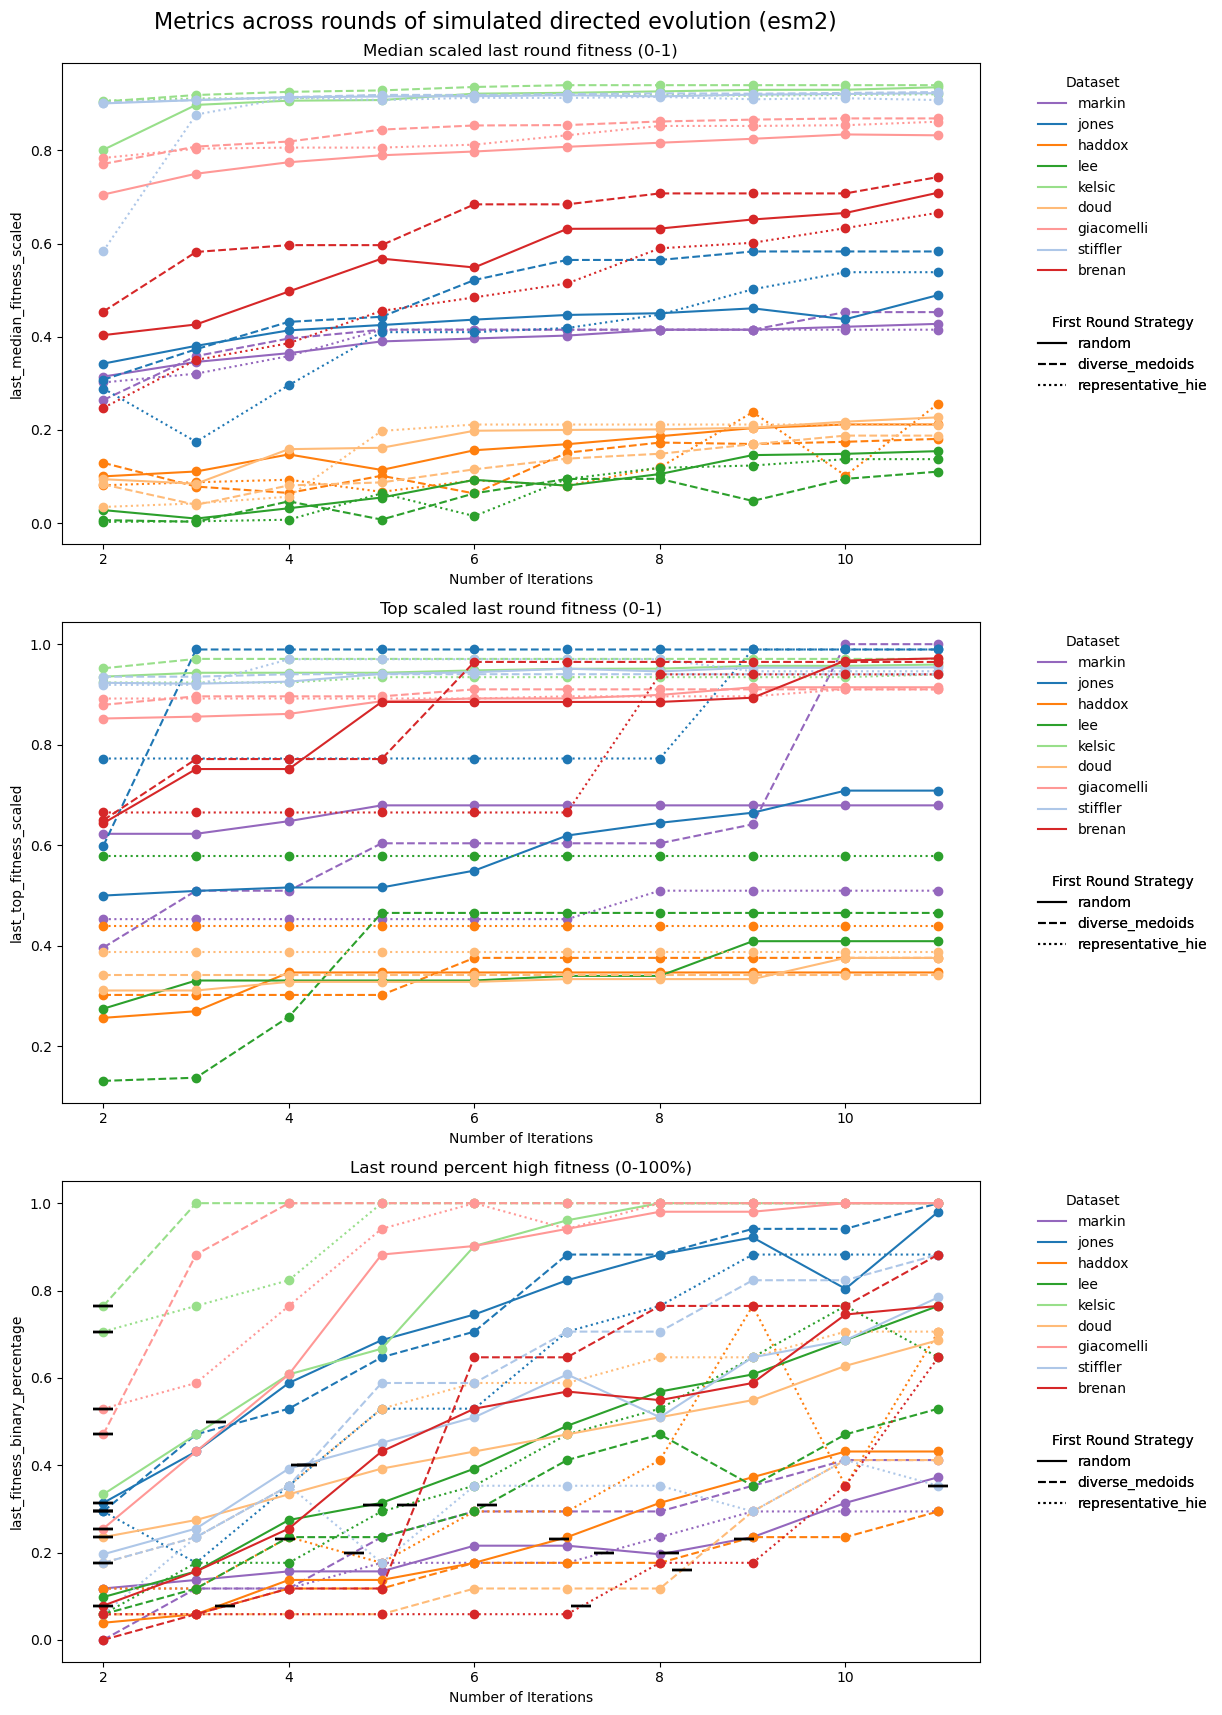

In [ ]:
generate_plots_first_round(esm="esm2")


In [151]:
# Specify the folder where the first round files are located
folder_path = "first_round"
# Get a list of all CSV files in the folder
file_names_list = [file_name for file_name in os.listdir(folder_path) if file_name.endswith(".csv")]
individual_dfs = []
for file_name in file_names_list:
    # Read the file
    file_path = os.path.join(folder_path, file_name)
    individual_df = pd.read_csv(file_path)
    # Get the file name by taking the first value before the first underscore
    base_name = file_name.split("_")[0]
    # Rename the columns
    individual_df = name_dataset(individual_df, base_name)
    # Save the scaled dataframe in the list
    individual_dfs.append(individual_df)
# Concatenate all the scaled dataframes
df = pd.concat(individual_dfs)

In [156]:
# subset df to num_iterations = 2, and first_round = representative hie
df_first_round = df[df['num_iterations'] == 2]
df_first_round = df_first_round[df_first_round['first_round_strategy'] == 'representative_hie']
# select dataset and first_fitness_binary_percentage only, and print
df_first_round = df_first_round[['dataset', 'first_fitness_binary_percentage']]
df_first_round

,dataset,first_fitness_binary_percentage
2,markin,0.117647
2,jones,0.294118
2,haddox,0.117647
2,lee,0.058824
2,kelsic,0.705882
2,doud,0.176471
2,giacomelli,0.529412
2,stiffler,0.058824
2,brenan,0.058824


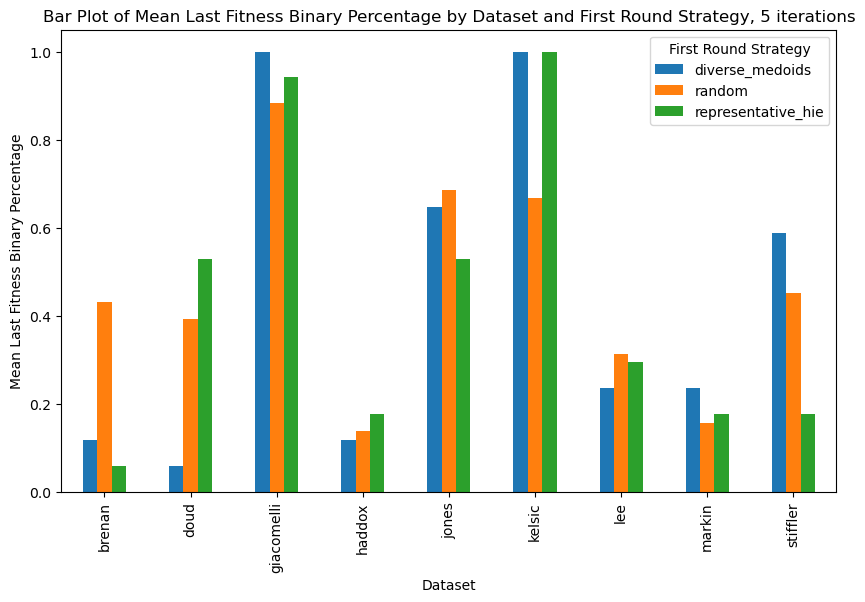

In [ ]:
# subset to num_iterations = 5
df_5 = df[df['num_iterations'] == 5]

# Group the data by 'dataset' and 'first_round_strategy', and calculate the mean of 'last_fitness_binary_percentage'
grouped_data = df_5.groupby(['dataset', 'first_round_strategy'])['last_fitness_binary_percentage'].mean()

# Create a bar plot
fig, ax = plt.subplots(figsize=(10, 6))
grouped_data.unstack().plot(kind='bar', ax=ax)

# Customize plot labels and title
plt.xlabel('Dataset')
plt.ylabel('Mean Last Fitness Binary Percentage')
plt.title('Bar Plot of Mean Last Fitness Binary Percentage by Dataset and First Round Strategy, 5 iterations')

# Add legend
plt.legend(title='First Round Strategy', loc='upper right')

plt.show()

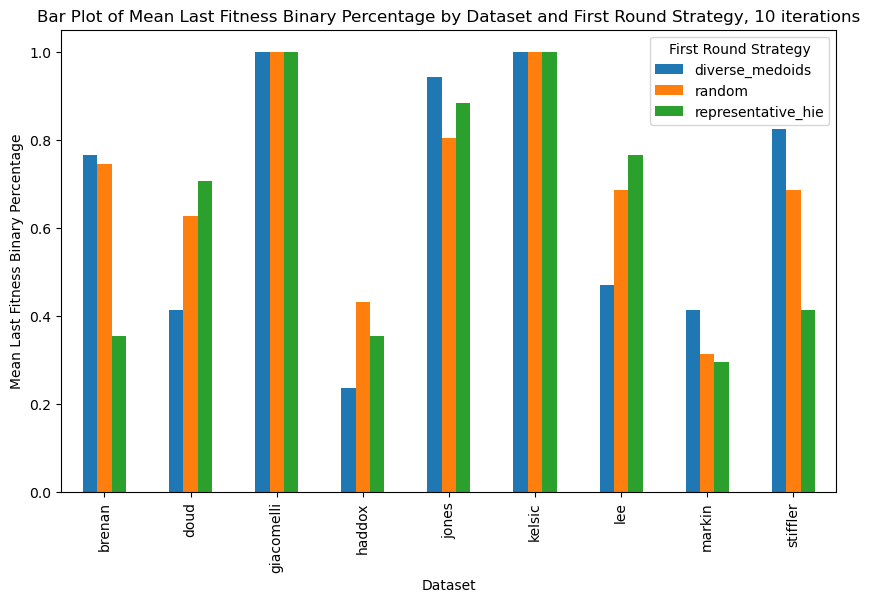

In [ ]:
# subset to num_iterations = 5
df_10 = df[df['num_iterations'] == 10]

# Group the data by 'dataset' and 'first_round_strategy', and calculate the mean of 'last_fitness_binary_percentage'
grouped_data = df_10.groupby(['dataset', 'first_round_strategy'])['last_fitness_binary_percentage'].mean()

# Create a bar plot
fig, ax = plt.subplots(figsize=(10, 6))
grouped_data.unstack().plot(kind='bar', ax=ax)

# Customize plot labels and title
plt.xlabel('Dataset')
plt.ylabel('Mean Last Fitness Binary Percentage')
plt.title('Bar Plot of Mean Last Fitness Binary Percentage by Dataset and First Round Strategy, 10 iterations')

# Add legend
plt.legend(title='First Round Strategy', loc='upper right')

plt.show()